In [1]:
# Import
import os, cv2, random

import torch, torchvision
import detectron2
import scipy.io 

import numpy as np

from torch.utils.data import Dataset, DataLoader


In [16]:
phase = 'test'
fn = os.path.join(f'/workspace/face_mosaic/data/widerface/wider_face_split/wider_face_{phase}.mat')
metadata = scipy.io.loadmat(fn)
# print(metadata)
print(metadata.keys())
print(len(metadata['file_list']))
print(metadata['file_list'][0])

dict_keys(['__header__', '__version__', '__globals__', 'event_list', 'file_list'])
61
[array([[array(['0_Parade_marchingband_1_737'], dtype='<U27')],
        [array(['0_Parade_marchingband_1_494'], dtype='<U27')],
        [array(['0_Parade_Parade_0_338'], dtype='<U21')],
        [array(['0_Parade_marchingband_1_533'], dtype='<U27')],
        [array(['0_Parade_marchingband_1_62'], dtype='<U26')],
        [array(['0_Parade_marchingband_1_184'], dtype='<U27')],
        [array(['0_Parade_marchingband_1_120'], dtype='<U27')],
        [array(['0_Parade_Parade_0_832'], dtype='<U21')],
        [array(['0_Parade_marchingband_1_396'], dtype='<U27')],
        [array(['0_Parade_marchingband_1_432'], dtype='<U27')],
        [array(['0_Parade_Parade_0_613'], dtype='<U21')],
        [array(['0_Parade_Parade_0_729'], dtype='<U21')],
        [array(['0_Parade_marchingband_1_389'], dtype='<U27')],
        [array(['0_Parade_marchingband_1_85'], dtype='<U26')],
        [array(['0_Parade_Parade_0_918'], dt

In [18]:
phase = 'train'
img_dir = '/workspace/face_mosaic/data/widerface/'
img_dir = os.path.join(img_dir, phase, 'images')
img_dir


'/workspace/face_mosaic/data/widerface/train/images'

In [2]:
class WIDERFACE(Dataset):
    def __init__(self, img_dir, phase, annot_file, transform=None):
        super(WIDERFACE, self).__init__()
        self.img_dir = img_dir
        self.phase = phase
        self.transform = transform
        self.data = self._load_annotations(annot_file)

    def _load_annotations(self, annot_file):
        """
        @param annot_file : absolute path of annotation text file
        @return : list of annotations (type: dictionary)

            annotation = {
                'file name' : image_full_path,
                'num_faces' : num_faces,
                'bboxes' : bboxes
            }
        
        """
        data = []
        with open (annot_file, 'r') as f:
            lines = f.readlines()
        
        i = 0
        while i < len(lines):
            image_path = lines[i].strip()
            image_full_path = os.path.join(self.img_dir, image_path)
            num_faces = int(lines[i + 1].strip())
            bboxes = [] # even 1 bbox when num_faces = 0 
            for j in range(num_faces):
                bbox = list(map(int, lines[i + 2 + j].strip().split()))
                bboxes.append(bbox)
            
            annotation = {
                'file name': image_full_path,
                'num_faces': num_faces,
                'bboxes': bboxes
            }
            
            data.append(annotation)
            i += max(2 + num_faces, 3) # 3 when num_faces = 0 
        
        return data
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_full_path, num_faces, bboxes = self.data[index].values()
        image = cv2.imread(image_full_path)
        if image is None:
            raise ValueError(f"Image at path {image_full_path} not found!")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB
        bboxes = np.array(bboxes)
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            'image': image,
            'num_faces': num_faces,
            'bboxes': bboxes,
            } if self.phase != 'test' else {'image': image}

        return sample


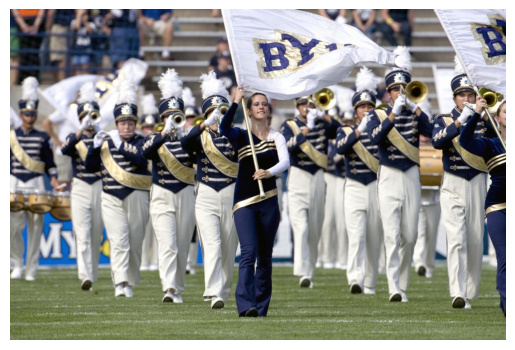

In [153]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/workspace/face_mosaic/data/widerface/train/images/0--Parade/0_Parade_marchingband_1_5.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off')  # 축 숨기기
plt.show()

In [3]:
img_dir = '/workspace/face_mosaic/data/widerface/train/images'
annot_file = '/workspace/face_mosaic/data/widerface/annotations/wider_face_train_bbx_gt.txt'
train_dataset = WIDERFACE(img_dir, 'train', annot_file)

In [4]:
for i in range(5):
    h, w, c = train_dataset[i]['image'].shape
    print(h, w, c)


1385 1024 3
1432 1024 3
768 1024 3
682 1024 3
852 1024 3


In [15]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

In [18]:
sample = next(iter(train_loader))
print(sample['image'])
print(sample['num_faces'])
print(sample['bboxes'])

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 265, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 127, in collate
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 127, in <dictcomp>
    return elem_type({key: collate([d[key] for d in batch], collate_fn_map=collate_fn_map) for key in elem})
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 171, in collate_numpy_array_fn
    return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 119, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 162, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
RuntimeError: stack expects each tensor to be equal size, but got [518, 1024, 3] at entry 0 and [752, 1024, 3] at entry 1


In [17]:
for d in random.sample(train_loader, 3):
    print(d['num_faces'])

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}

        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]

        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width

        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

In [ ]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])